# FATES SP LH analysis

In [506]:
import os
import copy

import math
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dask_jobqueue import PBSCluster
from dask.distributed import Client

## PBS Cluster Setup

In [507]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                     # The number of cores you want
    memory='25GB',                               # Amount of memory
    processes=1,                                 # How many processes
    queue='casper',                              # The type of queue to utilize
    local_directory='/glade/work/afoster',       # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',   # Specify resources
    project='P93300041',                         # Input your project ID here
    walltime='04:00:00',                         # Amount of wall time
    interface='ext',                             # Interface to use
)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35591 instead
  warnings.warn(


In [508]:
cluster.scale(30)

In [509]:
client = Client(cluster)

## Helper Functions

In [510]:
def get_ensemble(files, whittaker_ds):

    # read in dataset and attach other info
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='ensemble',
                           parallel=True, chunks = {'time': 60, 'ensemble': 100,
                                                    'gridcell': 200})

    ds['biome'] = whittaker_ds.biome
    ds['biome_name'] = whittaker_ds.biome_name

    return ds

In [511]:
def annual_mean(da):

    cf1, cf2 = cfs[da.name].values()

    days_per_month = da['time.daysinmonth']
    ann_mean = cf1*(days_per_month*da).groupby('time.year').sum()
    ann_mean.name = da.name
    return ann_mean

In [512]:
def adjust_lon(ds, lon_name):

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (
        ds
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
        .drop_vars(lon_name))

    ds = ds.rename({'_longitude_adjusted': lon_name})

    return ds

In [513]:
def month_wts(nyears):

    days_pm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    return xr.DataArray(np.tile(days_pm, nyears), dims='time')

In [514]:
def area_mean(ds, data_var, domain, cfs, land_area):
    '''
    Calculate area mean for data_var across gridcells, either globally or by biome
    ds:        dataset
    data_var:  data variable
    domain:   'global' or 'biome'
    cfs:       unit conversion factors
    land_area: land area dataset
    '''

    # update conversion factor if need be
    cf1, cf2 = cfs[data_var].values()
    if cf2 == 'intrinsic':
        if domain == 'global':
            cf2 = 1/land_area.sum()
        else:
            cf2 = 1/land_area.groupby(ds.biome).sum()

    # weight by landarea
    area_weighted = land_area*ds[data_var]

    # sort out domain groupings
    area_weighted['biome'] = ds.biome
    area_weighted = area_weighted.swap_dims({'gridcell': 'biome'})
    if domain == 'global':
        # every gridcell is in biome 1
        grid = 1+0*area_weighted.biome
    else:
        grid = area_weighted.biome

    # calculate area mean
    area_mean = cf2*area_weighted.groupby(grid).sum()

    if domain == 'global':
        # get rid of gridcell dimension
        area_mean = area_mean.mean(dim='biome')

    area_mean.name = data_var

    return area_mean

In [515]:
def get_map(ds, da):
    
    thedir = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir + thefile)

    out = np.zeros(sg.cclass.shape) + np.nan
    for c, (o, a) in enumerate(sg.rcent_coords):
        i = np.arange(400)[
            (abs(ds.grid1d_lat - a) < 0.1) &
            (abs(ds.grid1d_lon - o) < 0.1)]
        out[sg.cclass == c + 1] = i
    cclass = out.copy()
    cclass[np.isnan(out)] = 0

    sgmap = xr.Dataset()
    sgmap['cclass'] = xr.DataArray(cclass.astype(int), dims=['lat', 'lon'])
    sgmap['notnan'] = xr.DataArray(~np.isnan(out), dims=['lat', 'lon'])
    sgmap['lat'] = sg.lat
    sgmap['lon'] = sg.lon
    
    damap = da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()
    
    return damap

In [516]:
def calc_bylat(ann_map, land_area):
    cf1, cf2 = cfs[ann_map.name].values()
    globd = (ann_map)*land_area*cf2
    by_lat = globd.sum(dim='lon')

    return by_lat

In [605]:
def get_obsby_lat(global_dat, var, models, units, cf=None):

    #global_dat = global_dat.where(global_dat[var] > 0)
    if cf is not None:
        globd = (global_dat[var])*global_dat.land_area*cf
        globd = globd.where(globd.model.isin(models), drop = True)
        by_lat = globd.sum(dim='lon')
    else:
        globd = global_dat[var]
        globd = globd.where(globd.model.isin(models), drop = True)
        by_lat = globd.mean(dim='lon')

    by_lat.attrs = {'units': units, 'long_name': global_dat[var].attrs['long_name']}
    return globd, by_lat

In [518]:
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier
def truncate(n, decimals=0):
    multiplier = 10**decimals
    return int(n * multiplier) / multiplier

In [519]:
def plot_ensemble_bylat(ds_bylat, obs_bylat, varname, units):
    plt.figure(figsize=(7, 5))

    # colors for observations
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
                 (255, 187, 120), (44, 160, 44), (152, 223, 138),
                 (214, 39, 40), (255, 152, 150), (148, 103, 189),
                 (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127),
                 (199, 199, 199), (188, 189, 34), (219, 219, 141),
                 (23, 190, 207), (158, 218, 229)]
    for i in range(len(tableau20)):
        r, g, b = tableau20[i]
        tableau20[i] = (r/255., g/255., b/255.)

    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    lats = np.unique(ds_bylat.lat)
    quantiles = [1, 5, 25]
    cols = ["#c1c4c8", '#989ea4', '#70787f']
    labels = ['1st-99th percentile', '5th-95th percentile',
              '25th-75th percentile']

    plt.ylim(-90, 90)
    plt.yticks(range(-90, 91, 15), [str(x) + "º" for x in range(-90, 91, 15)],
               fontsize=10)
    plt.xticks(fontsize=10)
    plt.tick_params(bottom=False, top=False, left=False, right=False)

    minvar = truncate(ds_bylat.min())
    maxvar = round_up(ds_bylat.max())
    for y in range(-90, 91, 15):
        plt.plot(range(math.floor(minvar), math.ceil(maxvar) + 1),
                 [y] * len(range(math.floor(minvar), math.ceil(maxvar) + 1)),
                 "--", lw=0.5, color="black", alpha=0.3)

    for i, quantile in enumerate(quantiles):
        q1 = ds_bylat.isel(ensemble=slice(1, 501)).quantile(quantile/100,
                                                            dim='ensemble')
        q2 = ds_bylat.isel(ensemble=slice(1, 501)).quantile(1 - quantile/100,
                                                            dim='ensemble')
        plt.fill_betweenx(lats, q1, q2, color=cols[i], label=labels[i])

    plt.plot(ds_bylat.isel(ensemble=0), lats, color="black", lw=2,
             label='Default FATES-CTSM')
    for i, mod in enumerate(obs_bylat.model.values):
        plt.plot(obs_bylat.sel(model=mod), lats, color=tableau20[i], lw=2,
                 label=mod)

    plt.ylabel('Latitude (º)', fontsize=11)
    plt.xlabel(f'Annual {varname} {units}', fontsize=11)
    plt.title("Latin Hypercube Ensemble Spread", fontsize=11)
    plt.legend(loc='lower right', fontsize=9);

In [520]:
def map_function(ax, dat, cmap, vmax, vmin):
    ax.coastlines()
    ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
    pcm = ax.pcolormesh(dat.lon, dat.lat, dat,
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap=cmap, vmin=vmin, vmax=vmax)
    return pcm

In [521]:
def plot_global(var_glob, varname, units, cmap, vmin=None, vmax=None):

    if vmin is None:
        vmin = var_glob.min().values
    if vmax is None:
        vmax = var_glob.max().values
    
    figure, ax = plt.subplots(1, 1, figsize=(13, 6),
                                subplot_kw=dict(projection=ccrs.Robinson()))
    ax.set_extent([-180,180,-56,85], crs=ccrs.PlateCarree())
    pcm = map_function(ax, var_glob, cmap, vmax, vmin)
    cbar = figure.colorbar(pcm, ax=ax, shrink=0.5, orientation='horizontal')
    cbar.set_label(f'{varname} ({units})', size=10, fontweight='bold')

In [522]:
def plot_histogram(var, ens, obs_values, obs_names, varname, units):
    
    # colors for observations
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
                 (255, 187, 120), (44, 160, 44), (152, 223, 138),
                 (214, 39, 40), (255, 152, 150), (148, 103, 189),
                 (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127),
                 (199, 199, 199), (188, 189, 34), (219, 219, 141),
                 (23, 190, 207), (158, 218, 229)]
    for i in range(len(tableau20)):
        r, g, b = tableau20[i]
        tableau20[i] = (r/255., g/255., b/255.)

    plt.figure(figsize=(7, 5))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xticks(fontsize=11)
    plt.yticks(range(0, 20, 5), fontsize=11)
    
    plt.xlabel(f"Global Annual {varname} ({units})", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.hist(var.isel(ensemble=slice(1, ens+1)), ec="black", fc="#989ea4",
             bins=35)
    plt.axvline(x=var.isel(ensemble=0), color='black', label='Default CTSM-FATES',
                linestyle = ":", lw=2)
    for i in range(len(obs_values)):
        plt.axvline(x=obs_values[i], color=tableau20[i],
                    label=obs_names[i], linestyle = ":", lw=2)
    plt.legend(loc='upper left', fontsize=9)

## Directory Names and Conversion Factors

In [523]:
# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area_dat = xr.open_dataset(land_area_file)
land_area = land_area_dat.landarea  # km2

In [524]:
# random history
f = '/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist.clm2.h0.2014-12.nc'
tmp = xr.open_dataset(f)
global_land_area = tmp.area*tmp.landfrac

In [525]:
# whittaker biomes
whit = xr.open_dataset('/glade/work/afoster/FATES_calibration/CLM5PPE/pyth/whit/whitkey.nc')

In [687]:
# conversion factors
cfs = {'GPP': {'cf1': 24*60*60, 'cf2': 1e-6},
       #'EFLX_LH_TOT': {'cf1': 1/2.5e6*24*60*60, 'cf2': 1e-9},
       'EFLX_LH_TOT': {'cf1': 1/365, 'cf2': 'intrinsic'},
       'ASA': {'cf1': 1/365, 'cf2': 'intrinsic'},
       'SOILWATER_10CM': {'cf1': 1/365, 'cf2': 1e-9},
       'FSH': {'cf1': 1/365, 'cf2': 'intrinsic'},
       'Temp': {'cf1': 1/365, 'cf2': 'intrinsic'}}
units = {'GPP': 'PgC/yr',
         'EFLX_LH_TOT': 'TtH2O/yr',
         'ASA': '0-1',
         'SOILWATER_10CM': 'TtH2O',
         'FSH': 'W/m2',
         'Temp': 'degrees C'}

In [527]:
global_obs = xr.open_dataset('../observations/ILAMB_global_obs.nc')

In [614]:
gpp_obs, gpp_obs_bylat = get_obsby_lat(global_obs, 'gpp',
                                       ['FLUXCOM', 'WECANN', 'GBAF'], 'units', 1e6*1e-12)
et_obs, et_obs_bylat = get_obsby_lat(global_obs, 'et',
                                     ['FLUXCOM', 'DOLCE', 'CLASS', 'WECANN', 'GBAF'], 'units', 1e6*1e-12*1e-3)
sh_obs, sh_obs_bylat = get_obsby_lat(global_obs, 'sh',
                                     ['FLUXCOM', 'CLASS', 'WECANN', 'GBAF'], 'units')

In [617]:
et_means = et_obs.sum(dim=['lat', 'lon'])
sh_means = sh_obs.mean(dim=['lat', 'lon'])

## Read in ensemble

In [662]:
ens = 300
if ens == 500:
    topdir = '/glade/work/afoster/FATES_calibration/FATES_SP_LH/hist_500'
elif ens == 300:
    topdir = '/glade/work/afoster/FATES_calibration/FATES_SP_LH/hist'

In [663]:
files = sorted([os.path.join(topdir, file) for file in os.listdir(topdir)])
ds = get_ensemble(files, whit)

## GPP

In [664]:
gpp_ann = annual_mean(ds.GPP).mean(dim='year')
gpp_ann_map = get_map(ds.isel(ensemble=0), gpp_ann)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 21.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [665]:
global_land_area_interp = global_land_area.interp(lat=gpp_ann_map.lat,
                                                  lon=gpp_ann_map.lon)

In [666]:
gppbylat = calc_bylat(gpp_ann_map, global_land_area_interp)

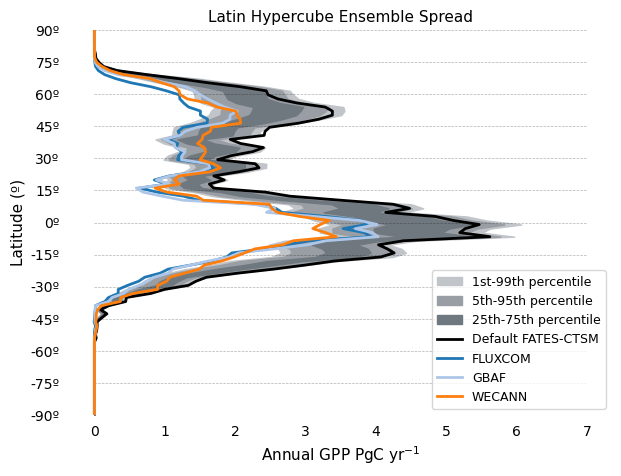

In [667]:
plot_ensemble_bylat(gppbylat, gpp_obs_bylat, 'GPP', 'PgC yr$^{-1}$')
plt.savefig(os.path.join("../LH/LH_output_global", f"gpp_LH{ens}_spread.png"),
            bbox_inches="tight")

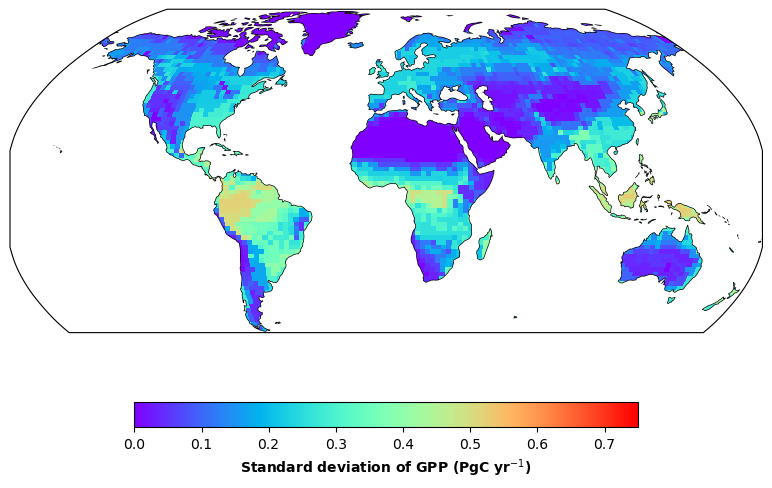

In [668]:
gpp_sd = gpp_ann_map.isel(ensemble=slice(1, ens+1)).std(dim='ensemble')
plot_global(gpp_sd, 'Standard deviation of GPP', 'PgC yr$^{-1}$', 'rainbow', vmax=0.75)
plt.savefig(f'../LH/LH_output_global/gpp_global_sd_LH{ens}.png')

In [669]:
# global annual mean (PgC/yr)
gpp_glob_ann = annual_mean(area_mean(ds, 'GPP', 'global', cfs, land_area)).mean(dim='year').compute()

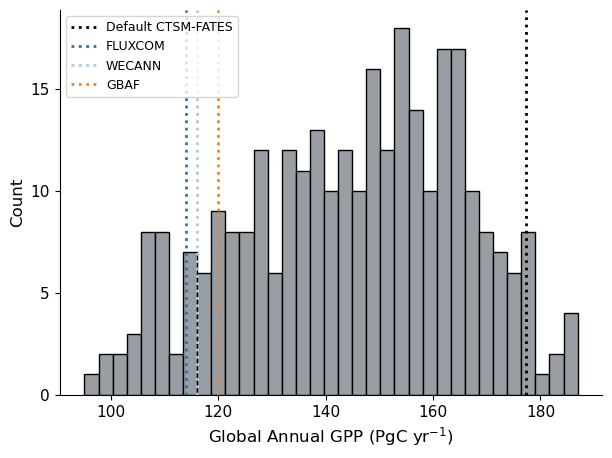

In [670]:
plot_histogram(gpp_glob_ann, ens, [114, 116, 120], ['FLUXCOM', 'WECANN', 'GBAF'],
               'GPP', 'PgC yr$^{-1}$')
plt.savefig(f'../LH/LH_output_global/gpp_global_annual_LH{ens}.png')

## Global Annual Evapotranspiration

In [688]:
et_ann = annual_mean(ds.EFLX_LH_TOT).mean(dim='year')
et_ann_map = get_map(ds.isel(ensemble=0), et_ann)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 22.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [672]:
et_bylat = calc_bylat(et_ann_map, global_land_area_interp)

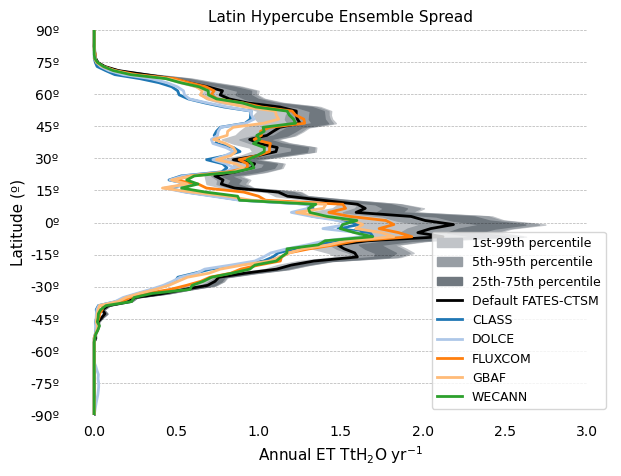

In [673]:
plot_ensemble_bylat(et_bylat, et_obs_bylat, 'ET', 'TtH$_2$O yr$^{-1}$')
plt.savefig(os.path.join("../LH/LH_output_global", f"et_LH{ens}_spread.png"),
            bbox_inches="tight")

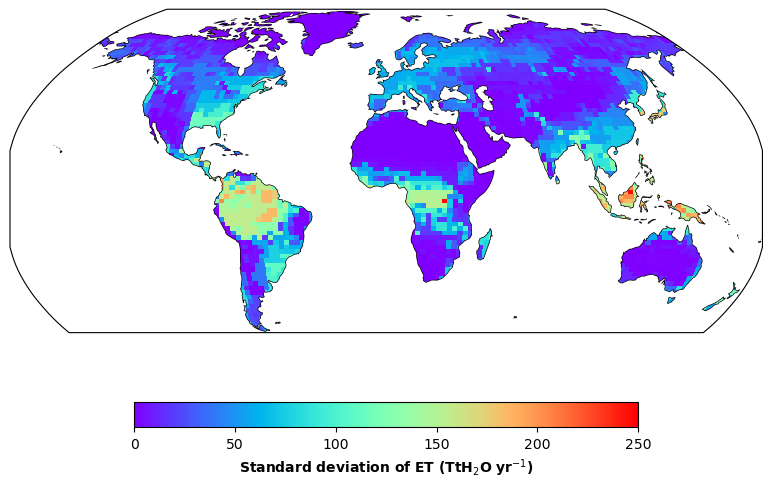

In [674]:
et_sd = et_ann_map.isel(ensemble=slice(1, ens+1)).std(dim='ensemble')
plot_global(et_sd, 'Standard deviation of ET', 'TtH$_2$O yr$^{-1}$', 'rainbow', vmax=250)
plt.savefig(f'../LH/LH_output_global/et_global_sd_LH{ens}.png')

In [689]:
# global annual mean (TtH2O/yr)
lh_glob_ann = annual_mean(area_mean(ds, 'EFLX_LH_TOT', 'global', cfs, land_area)).mean(dim='year').compute()

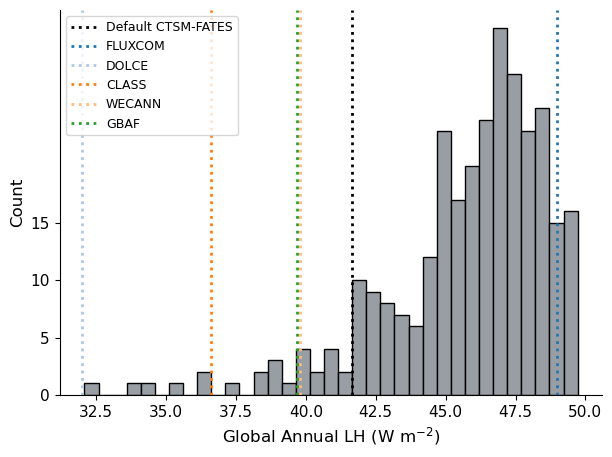

In [692]:
plot_histogram(lh_glob_ann, ens, [49.0, 32.0, 36.6, 39.8, 39.7],
               ['FLUXCOM', 'DOLCE', 'CLASS', 'WECANN', 'GBAF'], 'LH', 'W m$^{-2}$')
plt.savefig(f'../LH/LH_output_global/le_global_annual_LH{ens}.png')

## Global Annual Latent Heat Flux

In [ ]:
sh_ann = annual_mean(ds.EFLX_LH_TOT).mean(dim='year')
sh_ann_map = get_map(ds.isel(ensemble=0), sh_ann)

## Global Annual Sensible Heat

In [677]:
sh_ann = annual_mean(ds.FSH).mean(dim='year')
sh_ann_map = get_map(ds.isel(ensemble=0), sh_ann)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 22.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [678]:
globd = (sh_ann_map)
by_lat = globd.mean(dim='lon')

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


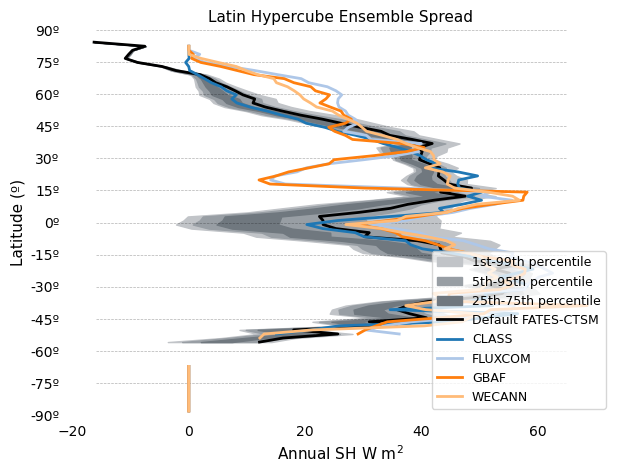

In [679]:
plot_ensemble_bylat(by_lat, sh_obs_bylat, 'SH', 'W m$^2$')
#plt.savefig(os.path.join("../LH/LH_output_global", f"sh_LH{ens}_spread.png"),
#            bbox_inches="tight")

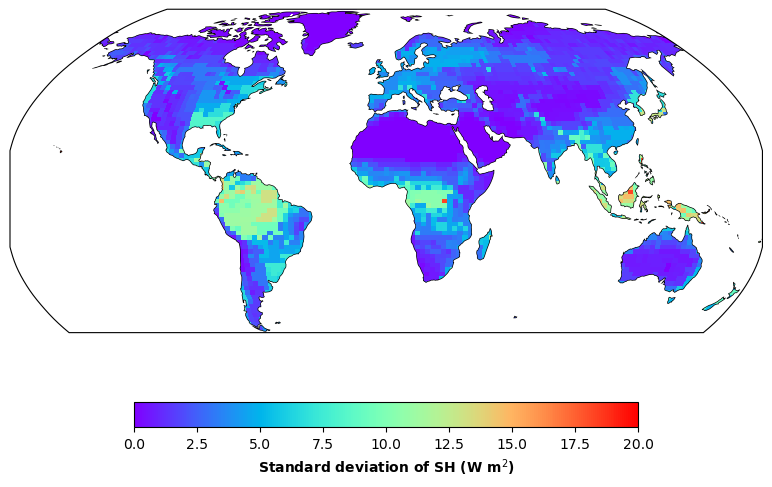

In [680]:
sh_sd = sh_ann_map.isel(ensemble=slice(1, ens+1)).std(dim='ensemble')
plot_global(sh_sd, 'Standard deviation of SH', 'W m$^2$', 'rainbow', vmax=20)
plt.savefig(f'../LH/LH_output_global/sh_global_sd_LH{ens}.png')

In [681]:
# global annual mean (W/m2)
sh_glob_ann = annual_mean(area_mean(ds, 'FSH', 'global', cfs, land_area)).mean(dim='year').compute()

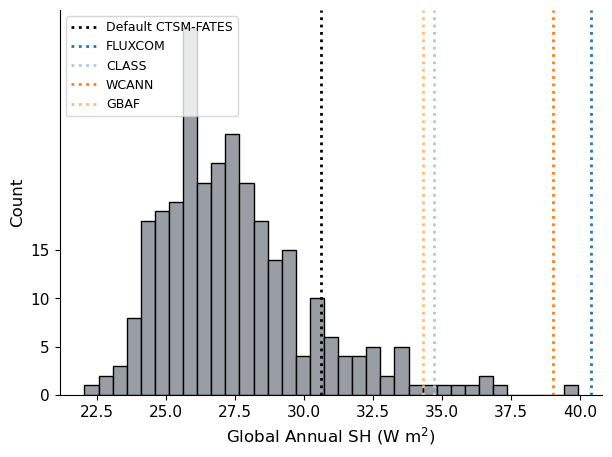

In [682]:
plot_histogram(sh_glob_ann, ens, [40.4, 34.7, 39.0, 34.3],
               ['FLUXCOM', 'CLASS', 'WCANN', 'GBAF'], 'SH', 'W m$^2$')
plt.savefig(f'../LH/LH_output_global/sh_global_annual_LH{ens}.png')

In [683]:
sh_glob_ann = sh_glob_ann.to_dataset(name='FSH')
et_glob_ann = et_glob_ann.to_dataset(name='EFLX_LH_TOT')
gpp_glob_ann = gpp_glob_ann.to_dataset(name='GPP')

In [684]:
all_out = xr.merge([gpp_glob_ann, et_glob_ann, sh_glob_ann])

In [686]:
all_out.to_netcdf(f'../LH/LH{ens}_global.nc')